In [1]:
import pickle
import numpy as np
import pandas as pd
from project_functions.sample_feed_v1_multi import SampleFeed
from project_functions import baseline
import matplotlib.pyplot as plt
from importlib import reload

from keras.models import load_model
from keras import losses
from keras import optimizers
from keras import metrics

from modeling_v1_run import TRAINING_WINDOW_SIZE, PREDICTED_WINDOW_SIZE, N_SAMPLES

2024-01-23 10:25:07.275723: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-23 10:25:07.301811: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-23 10:25:07.301869: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-23 10:25:07.301911: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-23 10:25:07.307130: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-23 10:25:07.308029: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

## Final model selection

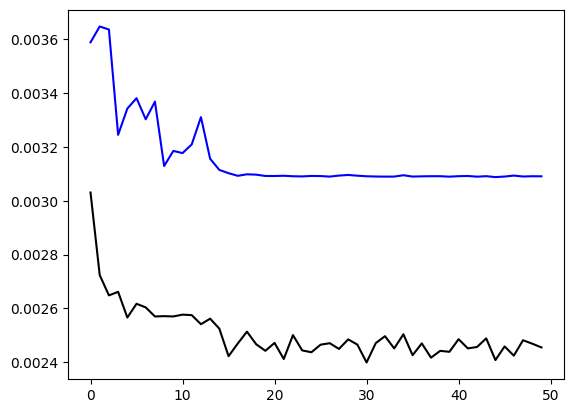

In [2]:
# Examine model history

with open("models/history/comb_history0101.pk", "rb") as file:
    model_history = pickle.load(file)

plt.plot(model_history.history['loss'], color='black')
plt.plot(model_history.history['val_loss'], color='blue')

In [3]:
df_history = pd.DataFrame(model_history.history)
df_history['epoch'] = pd.to_numeric(df_history.index) + 1

In [4]:
# Select the best performing model

df_history.sort_values('val_root_mean_squared_error')[0:10]

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error,lr,epoch
44,0.002408,0.071164,0.003088,0.080647,0.00001,45
39,0.002439,0.071695,0.003090,0.080664,0.00001,40
42,0.002456,0.071927,0.003090,0.080669,0.00001,43
32,0.002497,0.072543,0.003090,0.080672,0.00001,33
33,0.002451,0.071808,0.003090,0.080672,0.00001,34
35,0.002426,0.071480,0.003090,0.080674,0.00001,36
45,0.002459,0.071978,0.003090,0.080675,0.00001,46
26,0.002471,0.072133,0.003090,0.080677,0.00001,27
47,0.002482,0.072284,0.003090,0.080677,0.00001,48
31,0.002471,0.072141,0.003090,0.080679,0.00001,32


In [5]:
# Load the chosen model

model = load_model("models/checkpoints/comb_0101_45-0.080647.keras")

# Final model evaluation

In [6]:
# Build the test dataset (not used for model validation)

features_test = dict(np.load("data/features_test.npz", allow_pickle=True))

with open("data/visits_scaler_test.pk", "rb") as file:
    visits_scaler_test = pickle.load(file)

sample_feed = SampleFeed(
    training_window_size = TRAINING_WINDOW_SIZE,
    predicted_window_size = PREDICTED_WINDOW_SIZE,
    samples_per_epoch = N_SAMPLES
    )

Xy_test = sample_feed.random_sample_array(features_test, samples_per_page=1, shuffle=False, seed=0)

In [7]:
# Evaluate model on the test dataset

model.evaluate(*Xy_test)

2118/2118 [==============================] - 21s 10ms/step - loss: 0.0031 - root_mean_squared_error: 0.0810


[0.0031132176518440247, 0.08104723691940308]

In [8]:
# Make predictions and inverse scaling

y_pred = model.predict(Xy_test[0])

X_test_rescaled = visits_scaler_test. \
    inverse_transform(Xy_test[0][0][:,:,0])

y_test_rescaled = visits_scaler_test. \
    inverse_transform(Xy_test[1])

y_pred_rescaled = visits_scaler_test. \
    inverse_transform(y_pred)

2118/2118 [==============================] - 23s 11ms/step


In [9]:
# Utils for plotting

def one_page_results(no):

    X_emp_i = X_test_rescaled[no,:]
    y_emp_i = y_test_rescaled[no,:]
    y_pred_i = y_pred_rescaled[no,:]

    xy_emp = np.concatenate([X_emp_i, y_emp_i.reshape(PREDICTED_WINDOW_SIZE)])
    xy_pred = np.concatenate([np.full_like(X_emp_i[:-1], np.nan), X_emp_i[-1:], y_pred_i.reshape(PREDICTED_WINDOW_SIZE)])

    return xy_emp, xy_pred

def results_gen():

    ips_arr = np.array(range(Xy_test[0][0].shape[0]))

    np.random.seed(0)
    np.random.shuffle(ips_arr)

    for ip in ips_arr:
        yield ip, one_page_results(ip)

def plot_results(xy_scaled_emp, xy_scaled_pred):

    plt.figure(figsize=(20, 8))
    plt.plot(xy_scaled_emp, color="black")
    plt.plot(xy_scaled_pred, color="blue")
    plt.show()

results_show_iter = results_gen()

31675


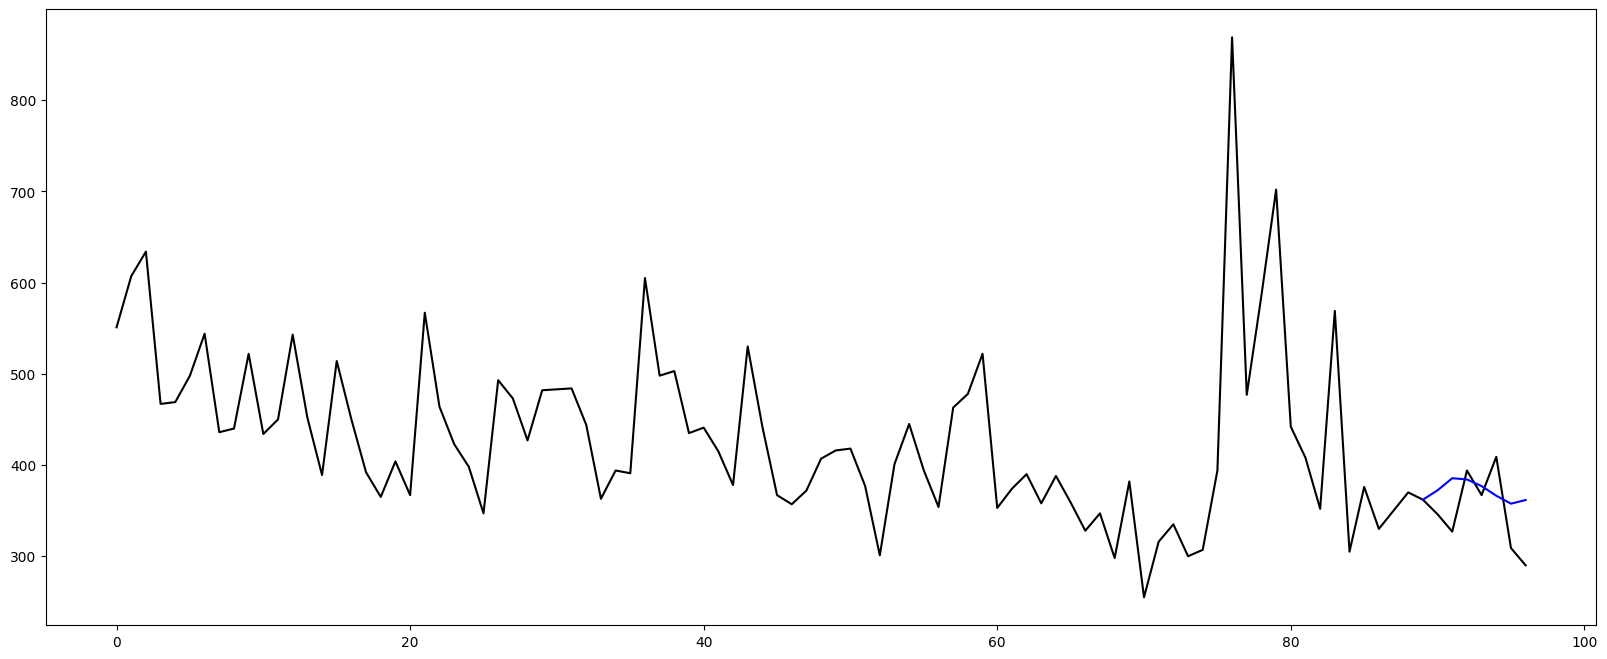

In [10]:
# Browsing results for different Wiki pages

ip, (xy_scaled_emp, xy_scaled_pred) = next(results_show_iter)

print(ip)
plot_results(xy_scaled_emp, xy_scaled_pred)

In [11]:
# Select representative examples for results description

representative_examples = [
    44148, 61555, 49345, 42420, 5726,
    9709, 66087, 17384, 2534, 17719,
    45459, 18972, 6287, 23952, 33636, 
    36134, 36972, 56528, 9675, 18508, 
    14268, 25413, 34399, 51223, 3066, 
    26959, 26382, 44801, 64919, 18078
    ]

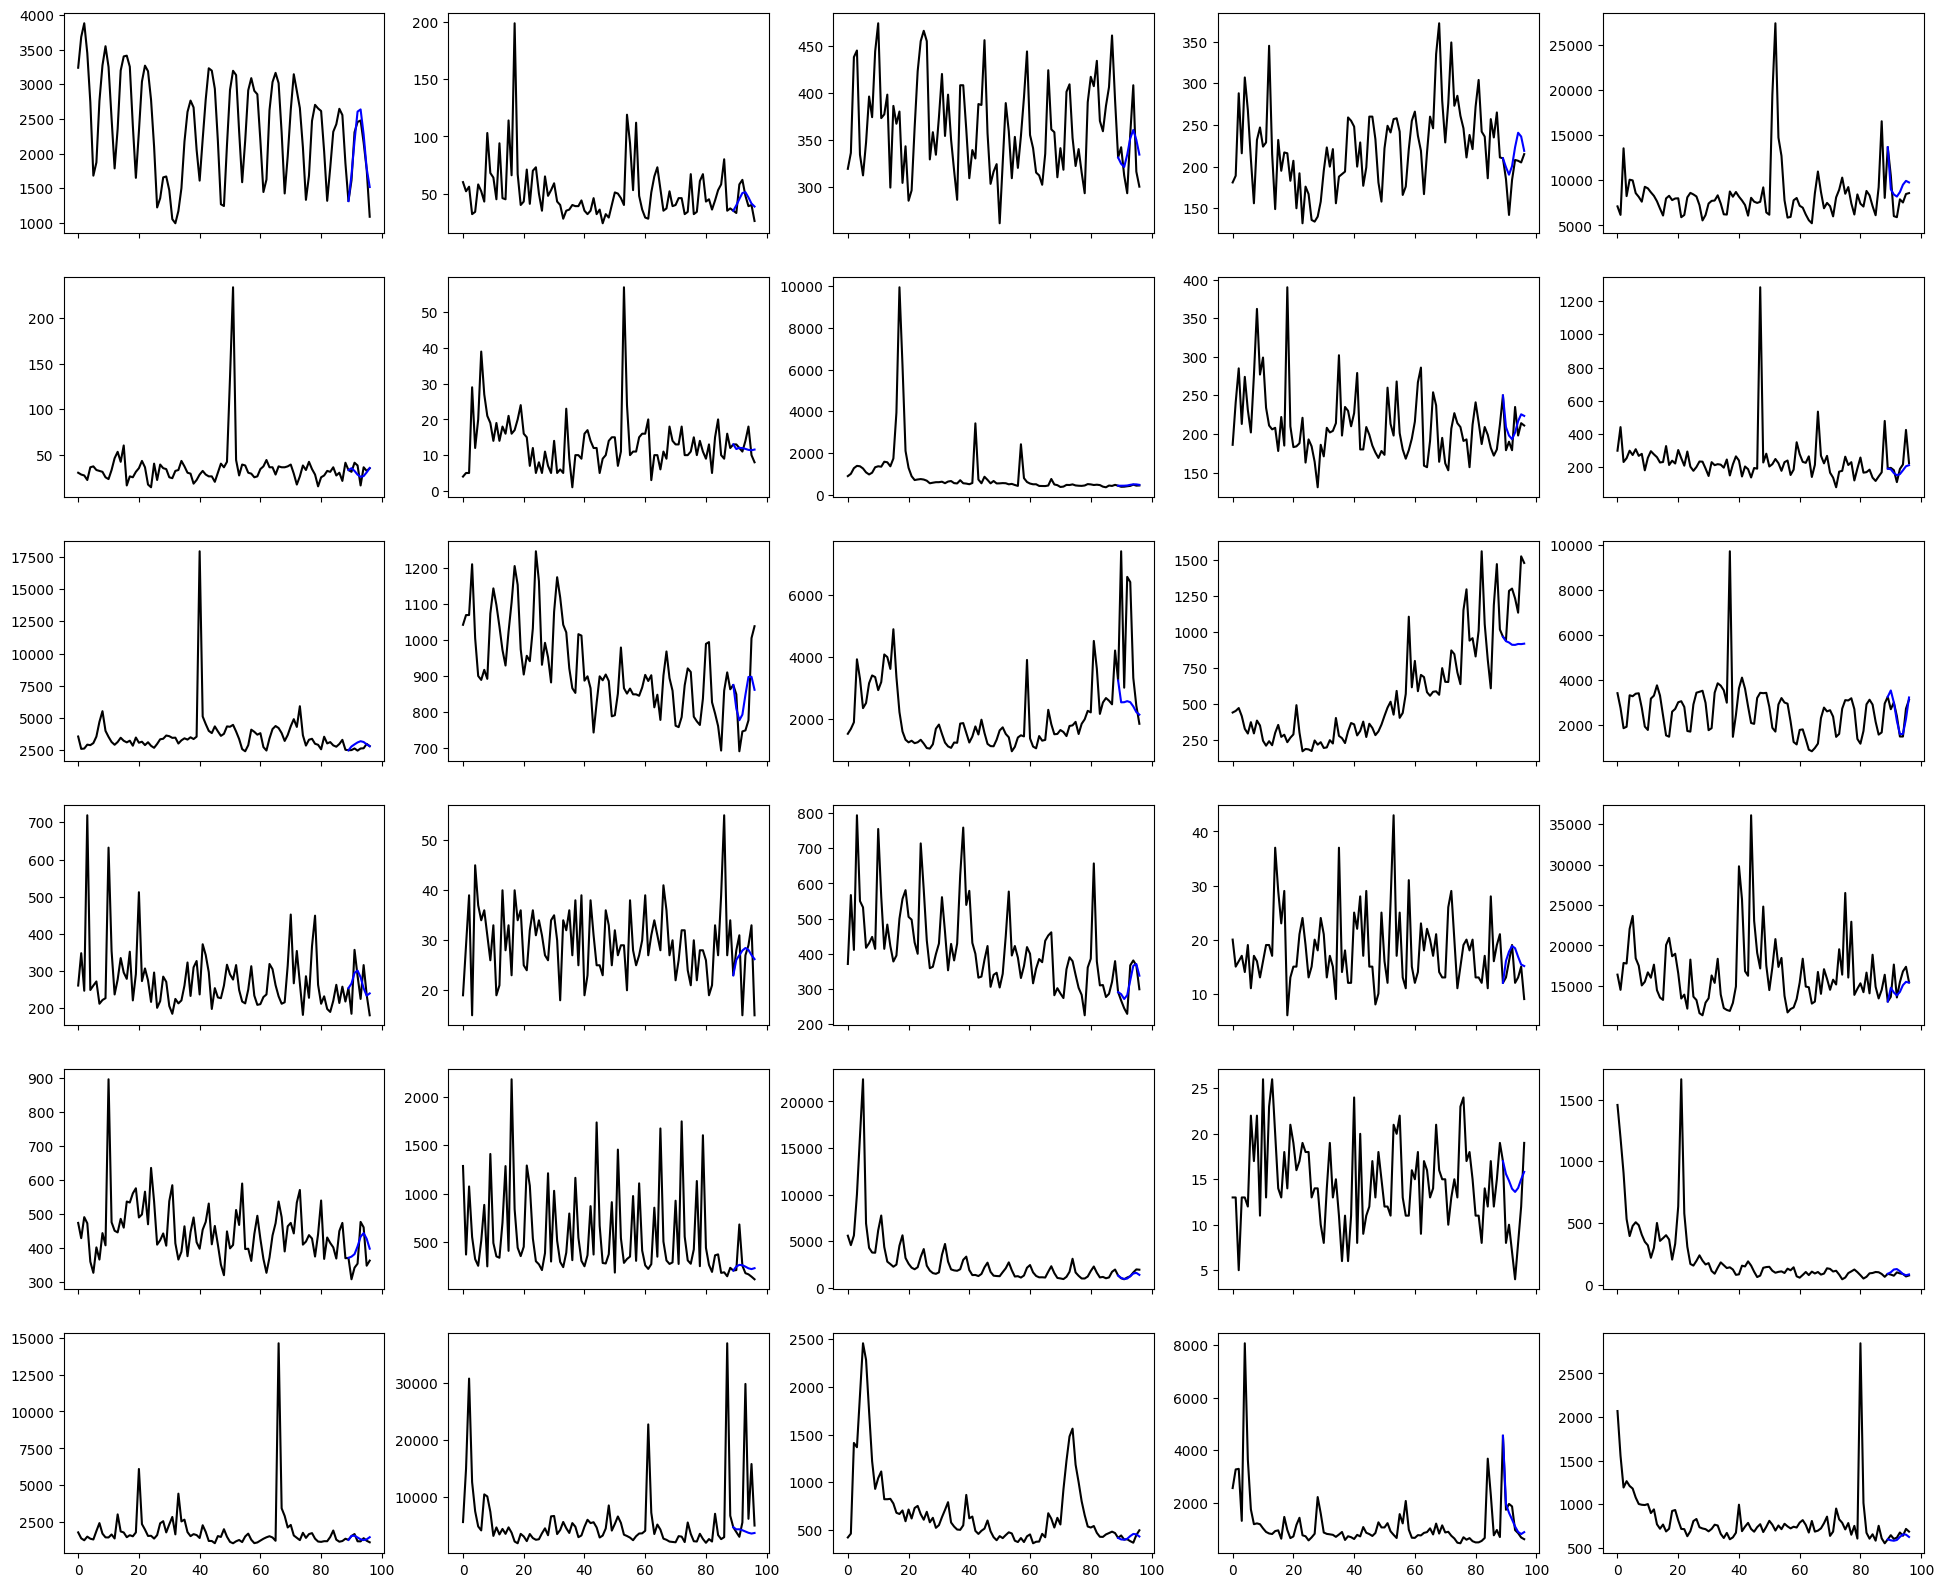

In [12]:
# Plot with some examples for results description

x_subplots = 6
y_subplots = 5

fig, axs = plt.subplots(x_subplots, y_subplots, sharex=True, sharey=False, figsize=(4*x_subplots,4*y_subplots))

ips = iter(representative_examples)

for ix in range(x_subplots):
    for iy in range(y_subplots):
        
        ip = next(ips)
        
        X_emp_i = X_test_rescaled[ip,:]
        y_emp_i = y_test_rescaled[ip,:]
        y_pred_i = y_pred_rescaled[ip,:]

        xy_emp = np.concatenate([X_emp_i, y_emp_i.reshape(PREDICTED_WINDOW_SIZE)])
        xy_pred = np.concatenate([np.full_like(X_emp_i[:-1], np.nan), X_emp_i[-1:], y_pred_i.reshape(PREDICTED_WINDOW_SIZE)])

        axs[ix,iy].plot(xy_emp, color="black")
        axs[ix,iy].plot(xy_pred, color="blue")

## Baseline models

In [13]:
# Build and evaluate the Naive Model

naive_model = baseline.NaiveModel(PREDICTED_WINDOW_SIZE)

naive_model.compile(
    loss=losses.Huber(0.25), 
    optimizer=optimizers.Adam(learning_rate=1e-3), 
    metrics=metrics.RootMeanSquaredError()
    )

y_pred_naive = naive_model.predict(Xy_test[0][0])

X_test_rescaled = visits_scaler_test. \
    inverse_transform(Xy_test[0][0][:,:,0])

y_test_rescaled = visits_scaler_test. \
    inverse_transform(Xy_test[1])

y_pred_naive_rescaled = visits_scaler_test. \
    inverse_transform(y_pred_naive)

2118/2118 [==============================] - 2s 699us/step


In [14]:
naive_model.evaluate(Xy_test[0][0], Xy_test[1])

2118/2118 [==============================] - 2s 780us/step - loss: 0.0052 - root_mean_squared_error: 0.1073


[0.005229682195931673, 0.10727650672197342]

In [15]:
# Build and evaluate the Random Model

random_model = baseline.RandomModel(PREDICTED_WINDOW_SIZE)

random_model.compile(
    loss=losses.Huber(0.25), 
    optimizer=optimizers.Adam(learning_rate=1e-3), 
    metrics=metrics.RootMeanSquaredError()
    )

y_pred_random = random_model.predict(Xy_test[0][0])

X_test_rescaled = visits_scaler_test. \
    inverse_transform(Xy_test[0][0][:,:,0])

y_test_rescaled = visits_scaler_test. \
    inverse_transform(Xy_test[1])

y_pred_random_rescaled = visits_scaler_test. \
    inverse_transform(y_pred_random)

2118/2118 [==============================] - 2s 952us/step


In [16]:
random_model.evaluate(Xy_test[0][0], Xy_test[1])

2118/2118 [==============================] - 2s 807us/step - loss: 0.0545 - root_mean_squared_error: 0.3949


[0.054455265402793884, 0.39494654536247253]

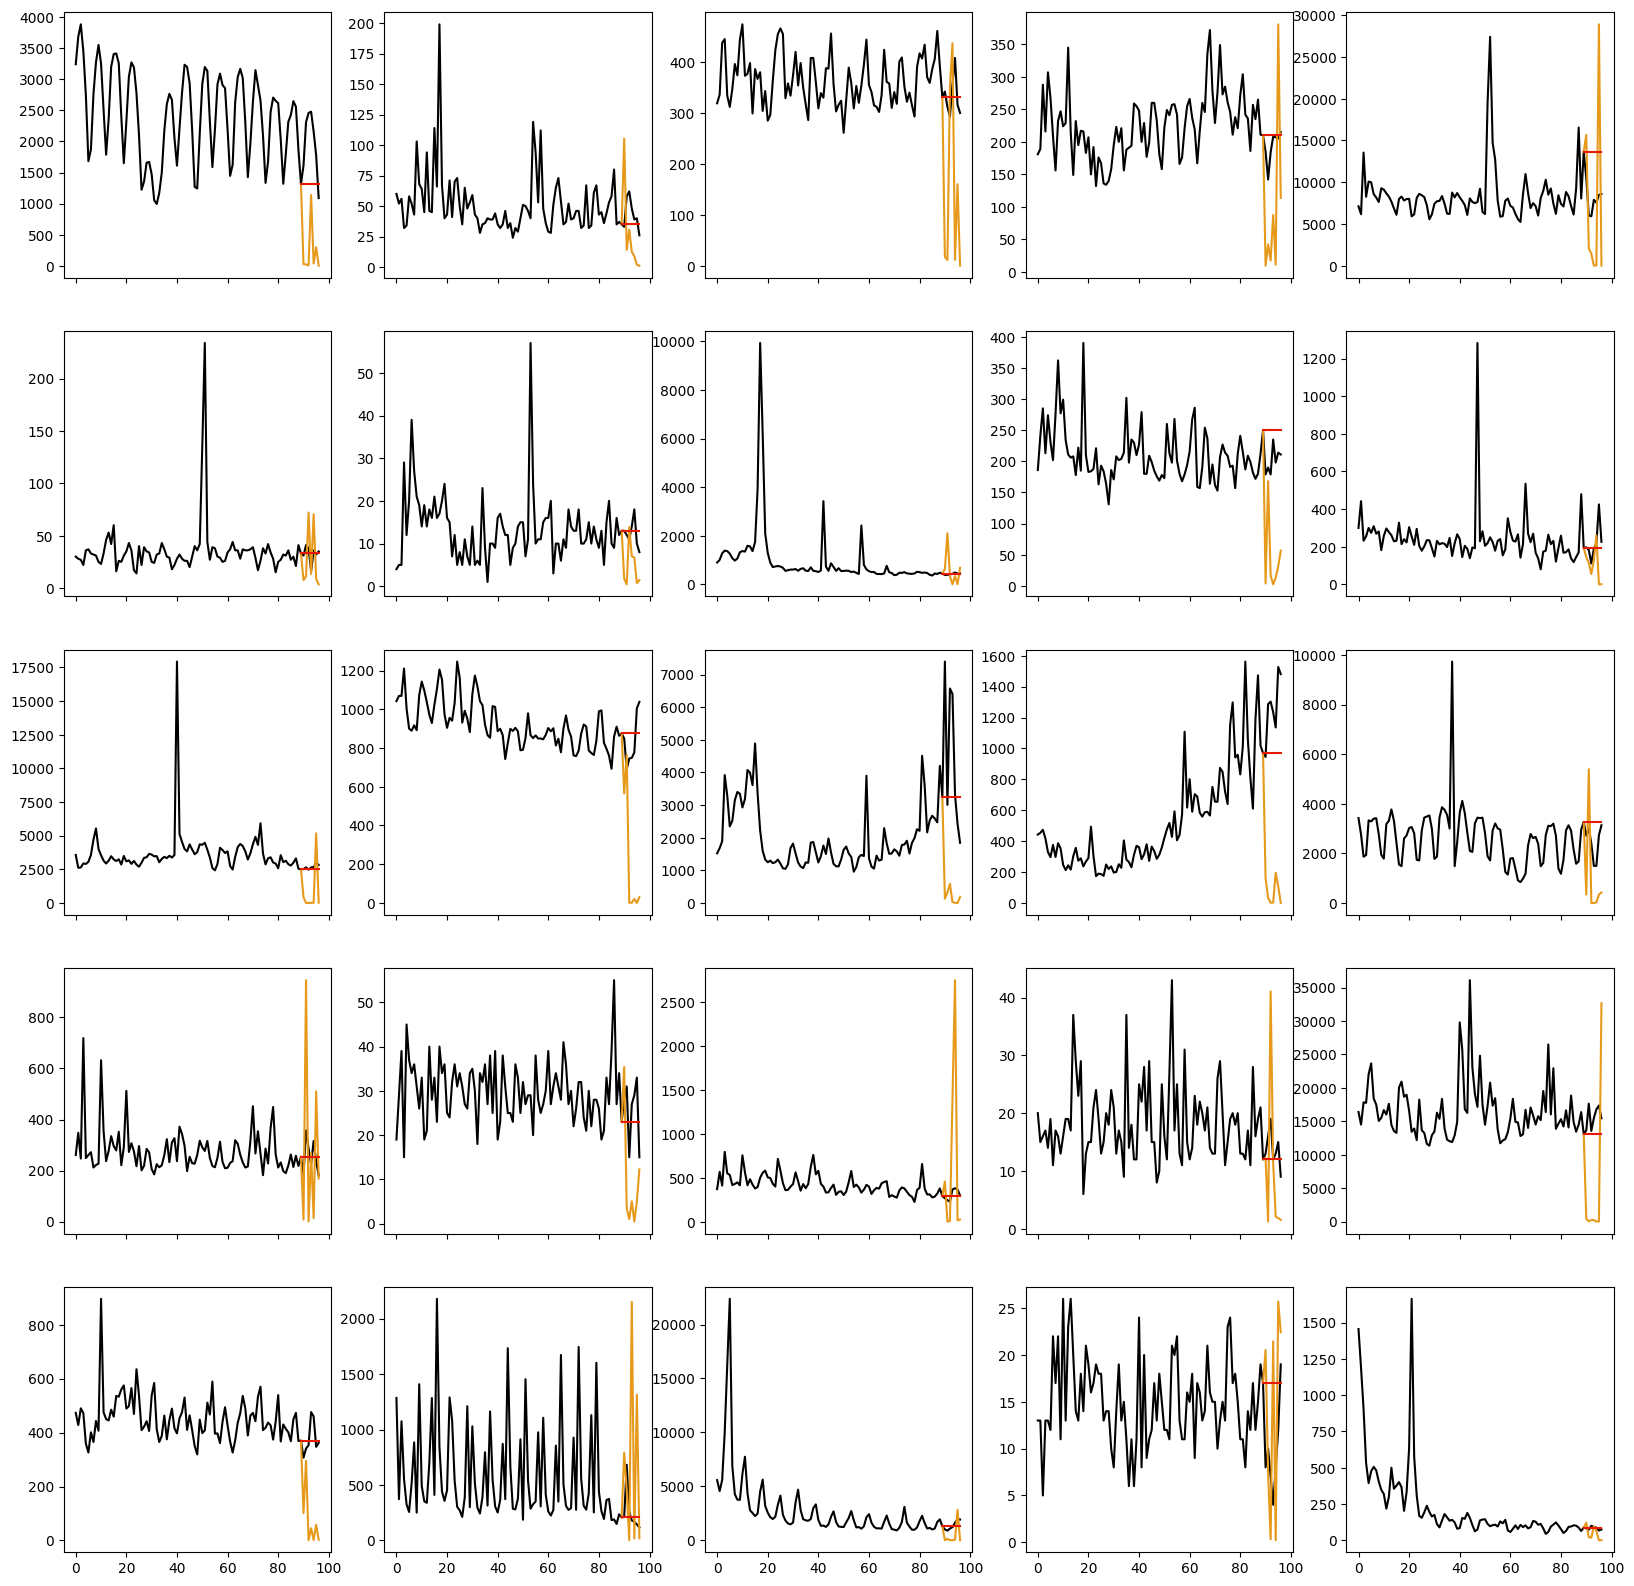

In [17]:
# Plot baseline models

x_subplots = 5
y_subplots = 5

fig, axs = plt.subplots(x_subplots, y_subplots, sharex=True, sharey=False, figsize=(4*x_subplots,4*y_subplots))

ips = iter(representative_examples)

y_pred_random_rescaled

for ix in range(x_subplots):
    for iy in range(y_subplots):
        
        ip = next(ips)
        
        X_emp_i = X_test_rescaled[ip,:]
        y_emp_i = y_test_rescaled[ip,:]
        y_pred_naive_i = y_pred_naive_rescaled[ip,:]
        y_pred_random_i = y_pred_random_rescaled[ip,:]

        xy_emp = np.concatenate([X_emp_i, y_emp_i.reshape(PREDICTED_WINDOW_SIZE)])
        xy_pred_naive = np.concatenate([np.full_like(X_emp_i[:-1], np.nan), X_emp_i[-1:], y_pred_naive_i.reshape(PREDICTED_WINDOW_SIZE)])
        xy_pred_random = np.concatenate([np.full_like(X_emp_i[:-1], np.nan), X_emp_i[-1:], y_pred_random_i.reshape(PREDICTED_WINDOW_SIZE)])

        axs[ix,iy].plot(xy_emp, color="black")
        axs[ix,iy].plot(xy_pred_random, color=(0.9, 0.6, 0.1))
        axs[ix,iy].plot(xy_pred_naive, color=(0.9, 0.1, 0.0))